NTU Road to Quantum Utility Workshop 2025

# Quantum kernel estimation
Boseong Kim (January 21, 2025) <br>
© IBM Corp. 2025

This code is based on "Quantum kernel estimation of Quantum Machine Learning" of IBM Quantum Learning which will be released soon.

## Single kernel matrix entry

### Step 1: Map classical inputs to a quantum problem

Let us first consider a data set with just a few features, say 10. We need at least two points to calculate the kernel matrix elements, so we will start with that, and import a few needed packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Two mock data points, including category labels, as in training
small_data = [[-0.194,0.114,-0.006,0.301,-0.359,-0.088,-0.156,0.342,-0.016,0.143,1],[-0.1,0.002,0.244,0.127,-0.064,-0.086,0.072,0.043,-0.053,0.02,-1]]

#Data points with labels removed, for inner product
train_data = [small_data[0][:-1],small_data[1][:-1]]

### Encoding
We will encode this data into quantum state using a quantum feature map. First we try the `ZZFeatureMap`. For 4 qubits, the circuit for the ZZFeaturemap is as follows.

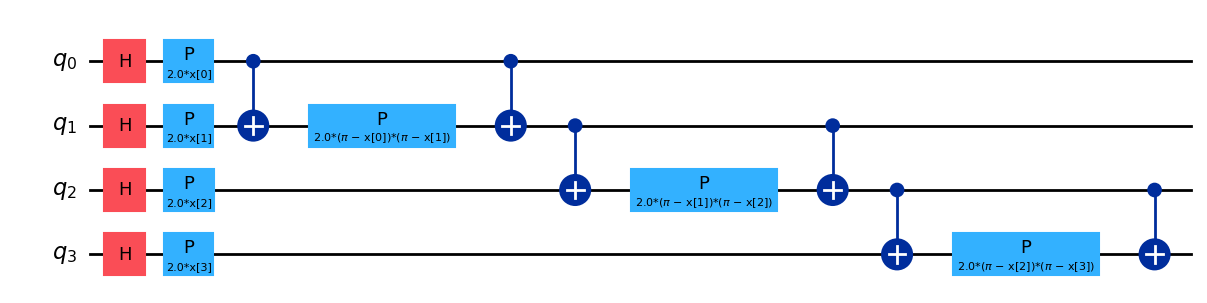

In [2]:
from qiskit.circuit.library import ZZFeatureMap

zz_fm = ZZFeatureMap(feature_dimension=4, entanglement='linear', reps=1)

zz_fm.decompose().draw("mpl", fold=-1)

We map `train_data` prepared above into the quantum state using ZZFeatureMap.

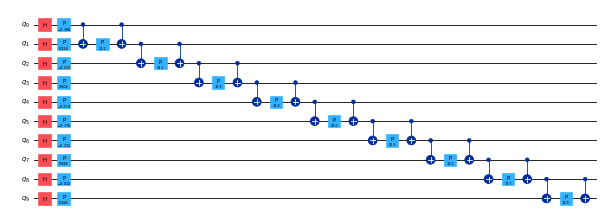

In [8]:
fm = ZZFeatureMap(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)

unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

unitary1.decompose().draw("mpl", scale=0.3, fold=-1)

Next, we create a quantum circuit that computes one element of the quantum kernel matrix using `UnitaryOverlap`. Also, we will check the Depth of the circuit.

circuit depth =  59


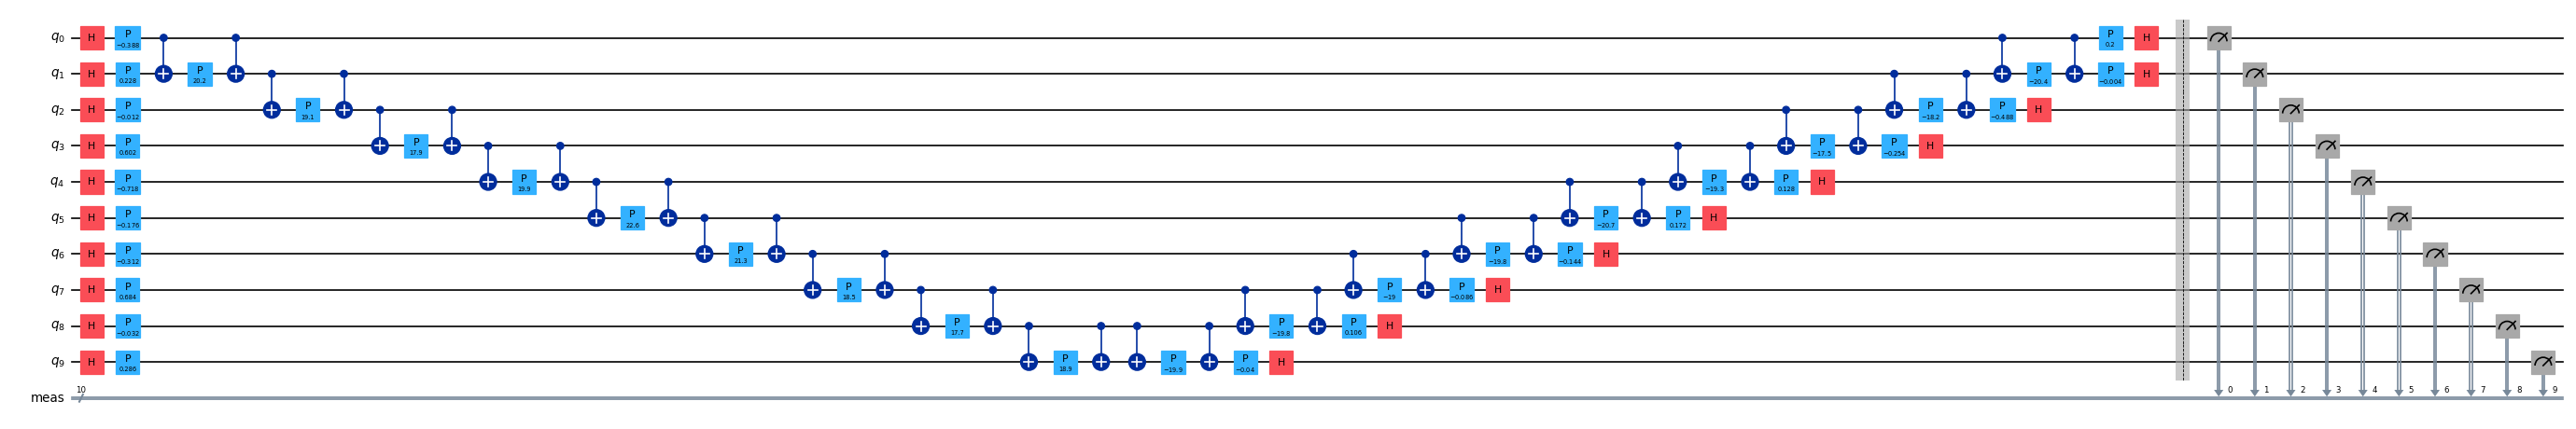

In [4]:
from qiskit.circuit.library import UnitaryOverlap
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, fold=-1)


You can see that the circuit is symmetrical. The left half is encoded  the training data `train_data[0]` and the right half is encoded the training data `train_data[1]`.

Next, let's try `ZFeatureMap`.


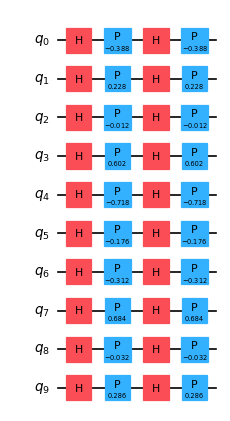

In [9]:
from qiskit.circuit.library import ZFeatureMap

fm = ZFeatureMap(feature_dimension=np.shape(train_data)[1])

unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

unitary1.decompose().draw("mpl", scale=0.6)

Again, we create a quantum circuit that computes one element of the quantum kernel matrix using `UnitaryOverlap`, and check the circuit depth.

circuit depth =  9


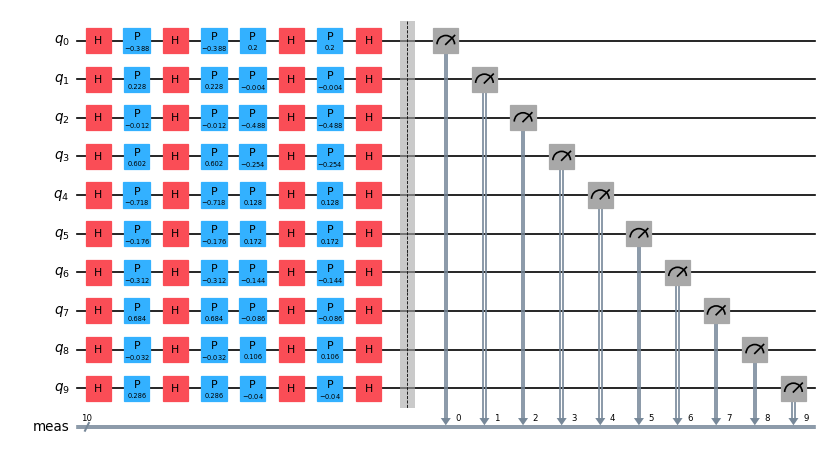

In [10]:
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, fold=-1)

The Depth of the circuit is definitely reduced. Therefore, we will use this circuit for the next calculation.

### Step 2: Optimize problem for quantum execution

We will use Aer Simulator as a backend and optimize the circuit above. Even if we don't use a real backend, we still need to transpile the circuit this time because transpiler cannot recognize ZFeatureMap.

In [11]:
# Use simulator
from qiskit_aer import AerSimulator
backend = AerSimulator()

# Optimize the circuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
overlap_ibm = pm.run(overlap_circ)

### Step 3: Execute using Qiskit Runtime Primitives

We will execute the circuit using Qiskit Runtime Primitives.

In [12]:
# Use simulator
from qiskit_ibm_runtime import Sampler
num_shots = 10000
sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()
counts_bit = results[0].data.meas.get_counts()
counts = results[0].data.meas.get_int_counts()

print(counts_bit)

{'0000000100': 432, '0000000000': 6891, '1000010000': 10, '0000010000': 688, '0001000000': 364, '0010000000': 678, '0010000100': 56, '1000001000': 4, '0001000100': 27, '0000000010': 84, '0010010000': 81, '0000000001': 63, '0001010000': 34, '0010000001': 14, '1010000000': 9, '0000001000': 222, '1000000000': 99, '0001000001': 2, '0010000010': 6, '0000010100': 46, '0011000000': 36, '0000011000': 24, '0010001000': 15, '0000001100': 15, '0111000000': 1, '0000010010': 7, '0000000110': 7, '1001000000': 3, '0000010001': 7, '0010010010': 1, '0010010100': 9, '0000001001': 3, '0011001000': 2, '0000000101': 5, '0001000010': 3, '0100000000': 6, '0001010010': 1, '0001001000': 8, '0001010100': 3, '1000000100': 3, '1000010101': 1, '0000001010': 5, '0010001100': 2, '0001001100': 2, '0000011001': 1, '0011000100': 1, '1000000010': 2, '0011010000': 6, '1100010101': 1, '0010011000': 1, '0010010001': 1, '0000011100': 1, '0101000000': 2, '1000010010': 1, '0110000000': 1, '1001001000': 1, '0001011000': 1, '10

### Step 4: Post-process, return result in classical format
The most useful measurement here is the probability of measuring the zero state $|0000000000\rangle$.

In [13]:
counts.get(0, 0.0)/num_shots

0.6891

This is the outcome we wanted: an estimate of the inner product (up to mod squared) of the vectors corresponding to two data points. If we want to look at the full distribution of measurement probabilities (or quasiprobabilities), we can do so using the `plot_distribution` function as shown below. One sees that for a large number of qubits, pictures like this quickly become intractable.

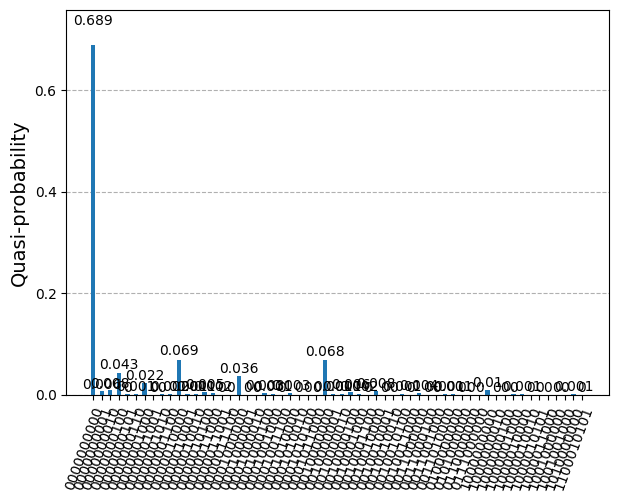

In [14]:
from qiskit.visualization import plot_distribution
plot_distribution(counts_bit)

From this information about only one inner product between two data points in the higher dimensional feature space, all we can say is that their overlap is fairly large compared to the maximum overlap (which would be 1.0). This could be an indicator that these two data points are somehow similar in nature and will be categorized in the same class classes. Or it could be an indicator that our feature map is not effective at mapping into a space where like data has a strong overlap and unlike data has a small overlap. In order to know which is true, we must apply our feature map to the entire set of data and see if the resulting kernel matrix can be manipulated to effectively separate classes with high accuracy.

This is the single quantum kernel entry of `train_data[0]` and `train_data[1]`. In the next section we will extend this process to an entire dataset, and show the classical machine learning workflow.

## 2. Full kernel matrix
In this section, we will extend the above process to the binary classification of a full dataset. So, we will implement classical machine learning in post-processing, and then we can obtain accuracy scores for our training.


### Step 1: Map classical inputs to a quantum problem
Now we will import an existing dataset for our classification. This dataset consists of 128 rows (data points) and 14 features on each point. There is a 15th element that indicates the binary category of each point ($\pm 1$). The dataset is imported below, or you can access the dataset and view its structure [here](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/data/dataset_graph7.csv).

We will use the first 90 data points for training, and the next 30 points for testing.

In [17]:
# !wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

# download https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv using python
import requests
url = 'https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv'
r = requests.get(url, allow_redirects=True)
open('dataset_graph7.csv', 'wb').write(r.content)

df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)

# Prepare training data
train_size = 90
X_train=df.values[0:train_size,:-1]
train_labels = df.values[0:train_size,-1]

#Prepare testing data
test_size = 30
X_test=df.values[train_size:train_size+test_size,:-1]
test_labels=df.values[train_size:train_size+test_size,-1]

We will prepare for storing multiple outputs by constructing an empty kernel matrix and an empty test matrix of appropriate dimensions.

In [19]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan) # Matrix of 90x90
test_matrix = np.full((test_size, num_samples), np.nan) # Matrix of 30x90

Now we create a feature map for encoding and mapping our classical data in a quantum circuit. 

In [20]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1] #14
num_qubits = int(num_features / 2) #7

#To use a custom feature map use the lines below.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits) # equivalent to H gate by inputing pi/2
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

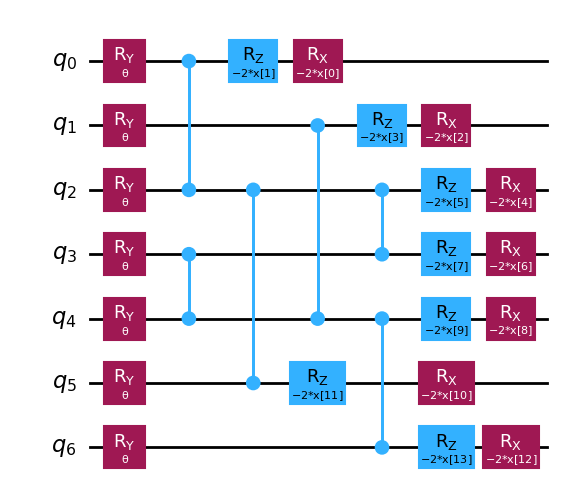

In [21]:
fm.draw("mpl") # 7 qubit circuit because encoding 2 data per each qubit

### Step 2 & 3: Optimize problem & execute using primitives
We will construct an overlap circuit. Note that we have leveraged the symmetry to the diagonal of a kernel matrix to reduce the number of calculations by 1/2. We have also simply set the diagonal elements to 1, as they should be in the absence of noise. 

In [22]:
num_shots = 10000

backend = AerSimulator()
sampler = Sampler(mode=backend)


for x1 in range(0,train_size):
    for x2 in range(x1+1,train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Create the overlap circuit
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        #These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        #Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0)/num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0)/num_shots
    #Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1,x1] =1    

print("training done")

#Similar process to above, but for testing data.
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Create the overlap circuit
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        counts = (
            sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        test_matrix[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

training done
test matrix done


It takes some time because we caluclate (90 x 90 x 1/2 - 90) elements and (30 x 90) elements: total 6705 elements.

Let's see the figure of two kernel matrices.

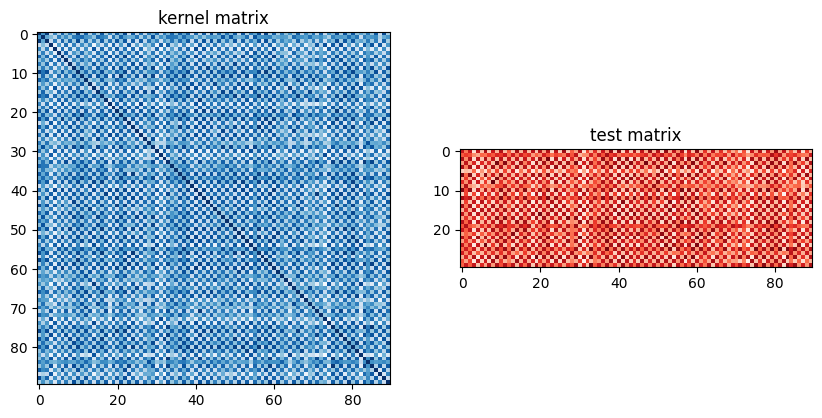

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("kernel matrix")
axs[1].imshow(np.asmatrix(test_matrix),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("test matrix")
plt.show()

### Step 4: Post-process, return result in classical format

Now that we have a kernel matrix and a similarly formatted test_matrix from quantum kernel methods, we can apply classical machine learning algorithms to make predictions about our test data and check its accuracy. We will start by importing Scikit-Learn's `sklearn.svc` , a support vector classifier (SVC). We must specify that we want the SVC to use our precomputed kernel using `kernel = precomputed` .

In [25]:
#import a support vector classifier from a classical ML package.
from sklearn.svm import SVC

#Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

Using `SVC.fit`, we can now feed in the kernel matrix and the training labels to obtain a fit. `SVC.predict` will predict the labels of testing data using our test_matrix. And `SVC.score` will score our test data and return our accuracy.

In [26]:
#Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)

#Predicts labels for test data using kernel matrix with training and test data
label_predict = qml_svc.predict(test_matrix)
print(label_predict, test_labels, sep="\n")

#Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
Precomputed kernel classification test score: 1.0


We see that the accuracy of our trained model was 100%. This is great, and it shows that QKE can work. But that is very different from quantum advantage. Classical kernels would likely have been able to solve this classification problem with 100% accuracy as well. There is much work to be done characterizing different data types and data relationships to see where quantum kernels will be most useful in the current utility era. You can try to modify parts of this workflow and study the effectiveness of various quantum feature maps.

## 3. Exercise: Classification of hand-written data

Next, we handle a subset of `0` and `1` from the handwritten digit image data set (MNIST data set) and perform QKE.

In [27]:
# Import Scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
from sklearn.decomposition import PCA # Principal component analysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

### Step 1: Map classical inputs to a quantum problem

In [ ]:
# load two classes of data (0 and 1) from a numeric data set
digits = datasets.load_digits(n_class=2)   

# Plot the first 10 images loaded
fig, axes = plt.subplots(1, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

You may see `0` in below data array. 0 is white and 16 is black.

In [ ]:
print(digits.images[0])

This data set contains a total of 360 data points. Each data point is an 8 x 8 numbered image, in an array, with each element being an integer from 0 (white) to 16 (black). As with classical classification algorithms, the dataset must be split and normalized into training (60 samples) and testing (20 samples). To use this dataset for the quantum classification algorithm, the range is scaled between -1 and 1 and the dimension is reduced to the number of qubits used (6 in this case).

In [ ]:
###### Split the dataset
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.4, random_state=22)

# Dimension deletion
n_dim = 6
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalization
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scaling
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Sample 60 for training and 20 for testing 
train_size = 60
X_train = sample_train[:train_size]
train_labels = labels_train[:train_size]

test_size = 20
X_test = sample_test[:test_size]
test_labels = labels_test[:test_size]

In [ ]:
print(X_train[0])

### Exercise 1: 

Build your own featuremap below.

In [ ]:
fm = ??? # input your featuremap

unitary1 = fm.assign_parameters(X_train[0]) # Depending on the featuremap, may need to be updated.
unitary2 = fm.assign_parameters(X_train[1]) # Depending on the featuremap, may need to be updated.

unitary1.decompose().draw("mpl", scale=0.6, fold=-1)

In [ ]:
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, fold=-1)

In [ ]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan) # Matrix of 60x60
test_matrix = np.full((test_size, num_samples), np.nan) # Matrix of 20x60

### Step 2 & 3: Optimize problem & execute using primitives



### Exercise 2: 

Assign parameters to unitary1 and unitary2.

In [ ]:
num_shots = 10000

backend = AerSimulator()
sampler = Sampler(mode=backend)


for x1 in range(0,train_size):
    for x2 in range(x1+1,train_size):
        unitary1 = ?? # input your unitary circuit here
        unitary2 = ?? # input your unitary circuit here

        # Create the overlap circuit
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()

        # Optimize the circuit
        pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
        overlap_ibm = pm.run(overlap_circ)
    
        #These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        #Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0)/num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0)/num_shots
    #Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1,x1] =1    

print("training done")

#Similar process to above, but for testing data.
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        unitary1 = ?? # input your unitary circuit here
        unitary2 = ?? # input your unitary circuit here        

        # Create the overlap circuit
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()

        # Optimize the circuit
        pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
        overlap_ibm = pm.run(overlap_circ)
    
        counts = (
            sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        test_matrix[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

Let's see the kernel_matrix and test_matrix.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(test_matrix),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

### Step 4: Post-process, return result in classical format

We will apply classical machine learning algorithms to make predictions about our test data and check its accuracy. 

In [ ]:
#Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

#Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)

#Predicts labels for test data using kernel matrix with training and test data
label_predict = qml_svc.predict(test_matrix)
print(label_predict, test_labels, sep="\n")

#Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

Good job! How was the score of your featuremap? If you have time, please try another featuremap to improve the score.

## Reference: For execution on the real device

To run it on a real device, specify a real device for the backend, transpile it for the real device, and run it. However, since each experiment takes long time, we don't do it now. And, please note that before executing on the real device, we should also try to reduce the circuit depth. The detail method will be released in IBM Quantum Learning later.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If this is your first time running your circuit on a real device, 
# make sure you copy your API Token from [IBM Quantum Platform](https://quantum.ibm.com/) 
# QiskitRuntimeService.save_account(token='<your_token>', overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")
service.backends()

In [ ]:
# You can specifiy the device 
# backend = service.backend('ibm_sherbrooke')

In [ ]:
#You can also identify the least busy device
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)